1. EDA
2. 함수 생성(Logistic Regression, Decision Tree, Random Forest)
3. Scaling
4. Logistic Regression
5. Decision Tree
6. Random Forest
7. GridSearchCV 적용
8. Metric: Accuracy
9. 총 성능 비교


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import graphviz

In [37]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

## 1.EDA

In [44]:
df_pd = pd.read_csv('https://raw.githubusercontent.com/rusita-ai/pyData/master/product.csv')

In [45]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15009 entries, 0 to 15008
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           15009 non-null  object 
 1   meanPriceEach  15009 non-null  float64
 2   totalOrder     15009 non-null  float64
 3   orderType_1    15009 non-null  float64
 4   orderType_2    15009 non-null  float64
 5   orderType_3    15009 non-null  float64
 6   totalBundle    15009 non-null  float64
 7   bundleType_1   15009 non-null  float64
 8   bundleType_2   15009 non-null  float64
 9   customerType   15009 non-null  object 
 10  FY             15009 non-null  int64  
 11  Country        15009 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 1.4+ MB


In [46]:
df_pd.head()

,Date,meanPriceEach,totalOrder,orderType_1,orderType_2,orderType_3,totalBundle,bundleType_1,bundleType_2,customerType,FY,Country
0,2015-01-04,1.56,58065.35,10049.66,25228.37,3672.89,19114.43,17280.89,1833.54,Online,2015,25
1,2015-01-04,1.10,2578275.12,575245.44,1311502.53,181058.65,510468.50,429166.89,80986.81,Offline,2015,25
2,2015-01-11,1.17,2335986.11,560119.16,1032606.49,191515.19,551745.27,465764.93,85966.27,Offline,2015,25
3,2015-01-11,1.52,65483.08,14570.74,30445.75,3170.11,17296.48,16715.45,581.03,Online,2015,25
4,2015-01-18,1.65,52559.10,11415.28,25306.56,3345.08,12492.18,10971.43,1520.75,Online,2015,25


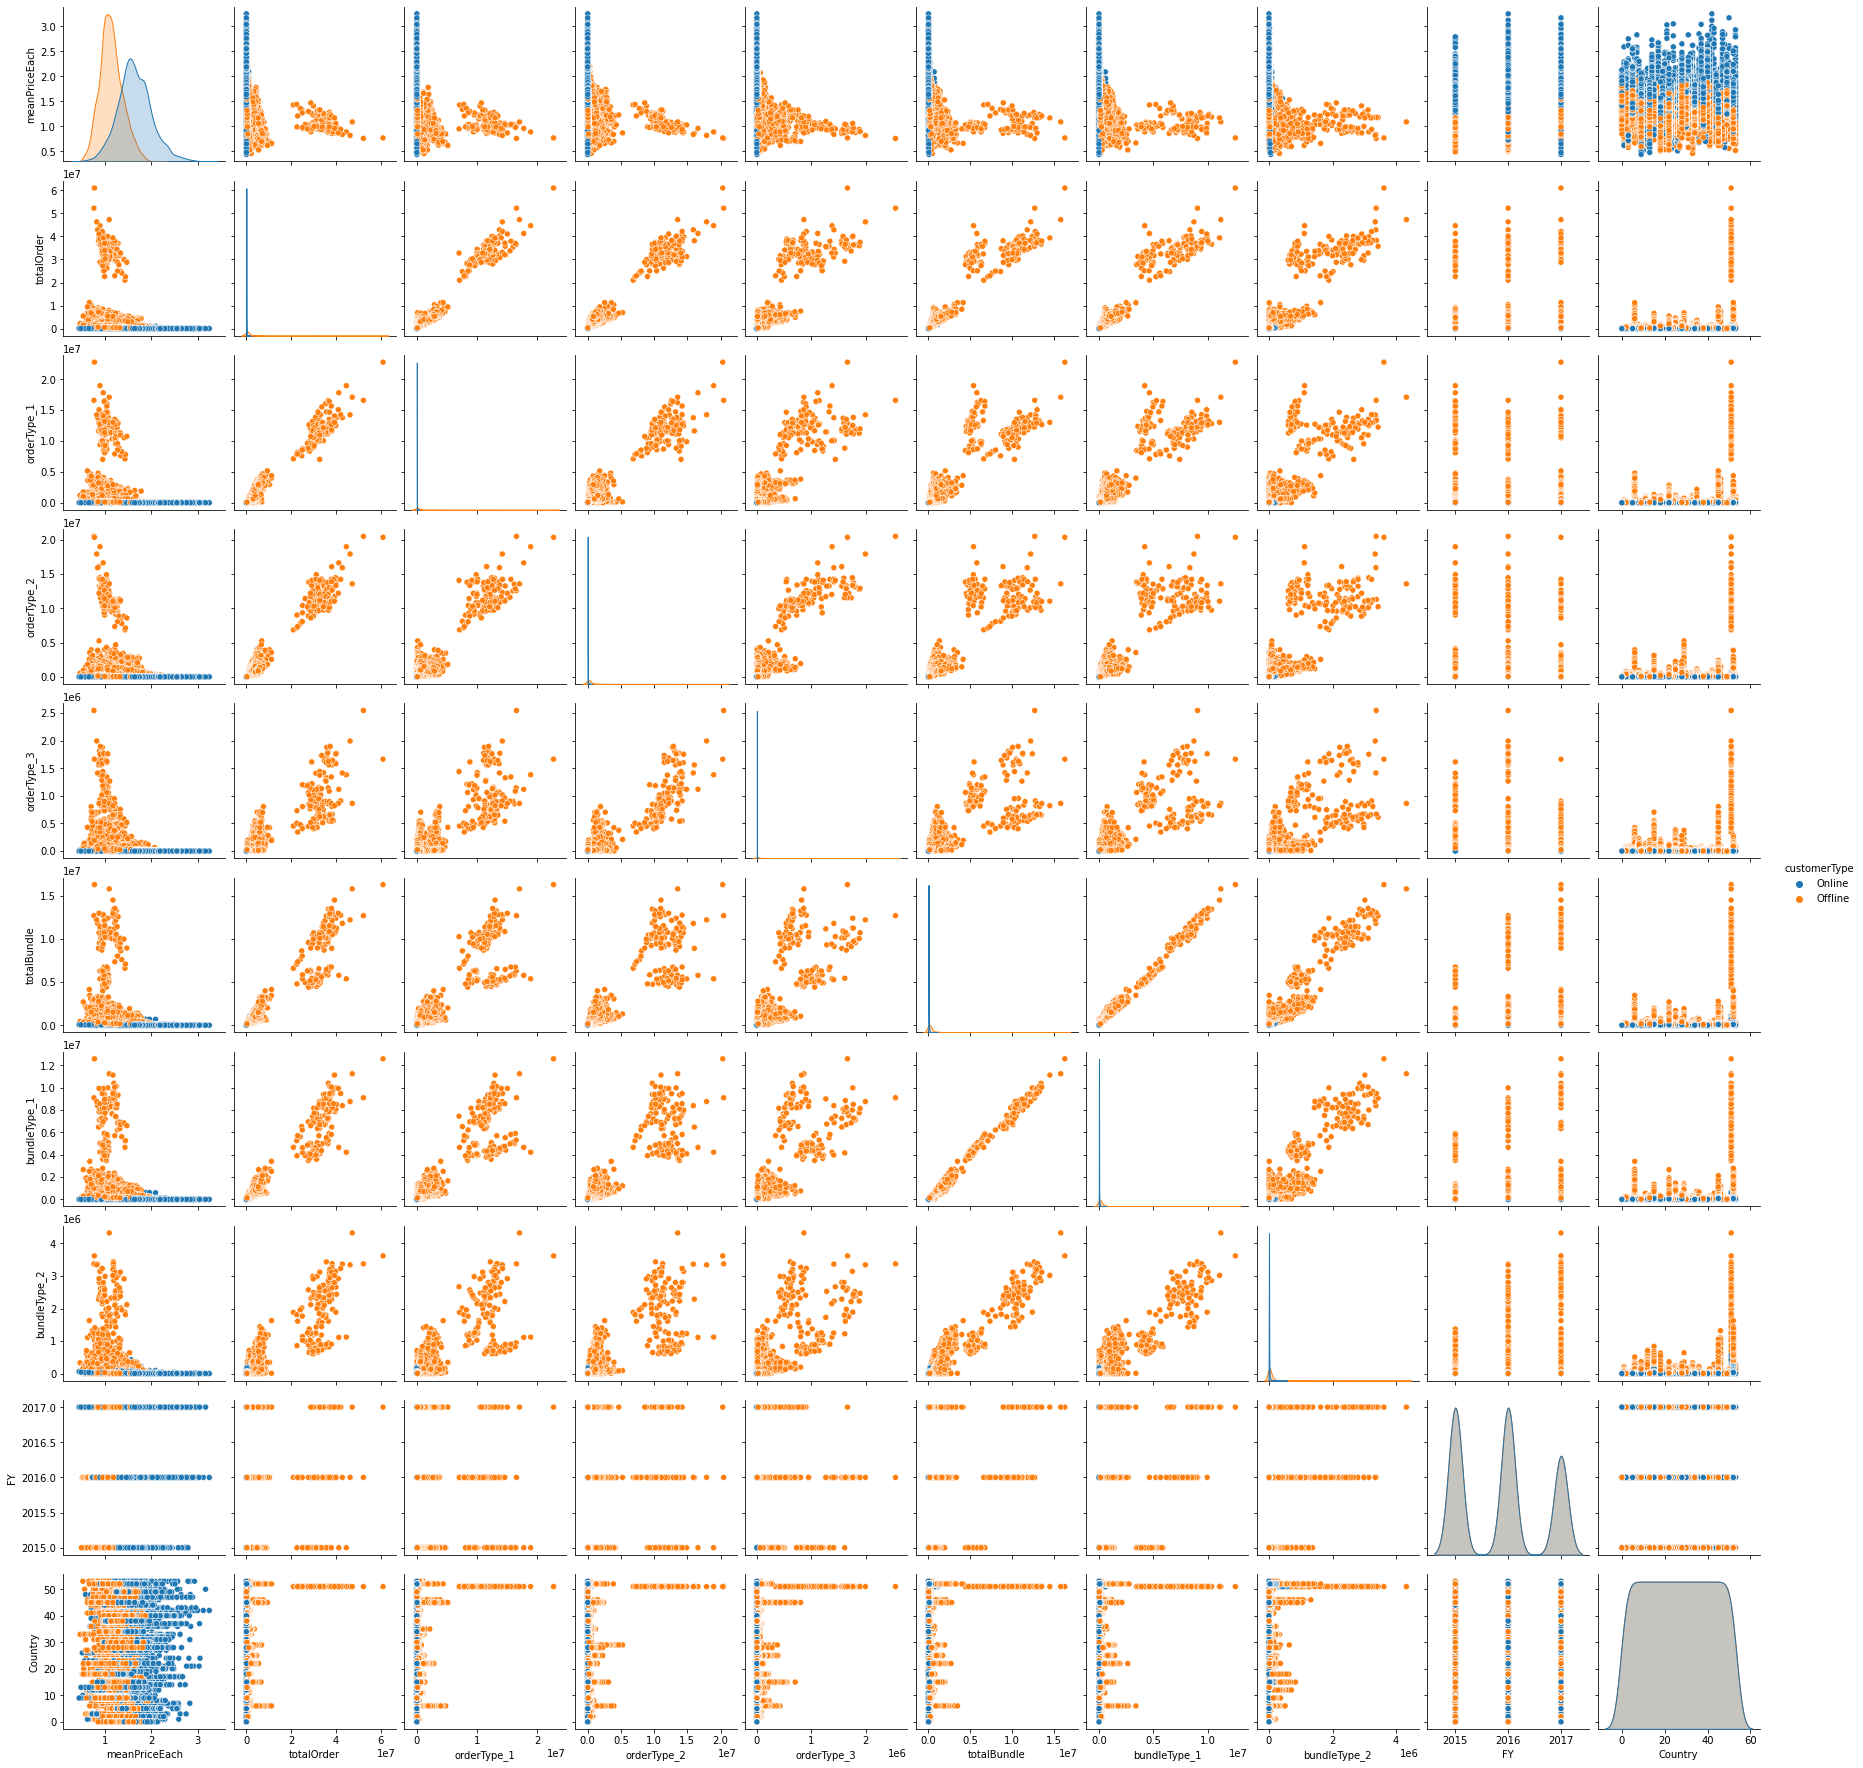

In [47]:
sns.pairplot(hue = 'customerType', 
             data = df_pd)
plt.show()

# totalOrder, totalBundle만 남기자

In [8]:
df_pd['customerType'].value_counts()

Offline    7506
Online     7503
Name: customerType, dtype: int64

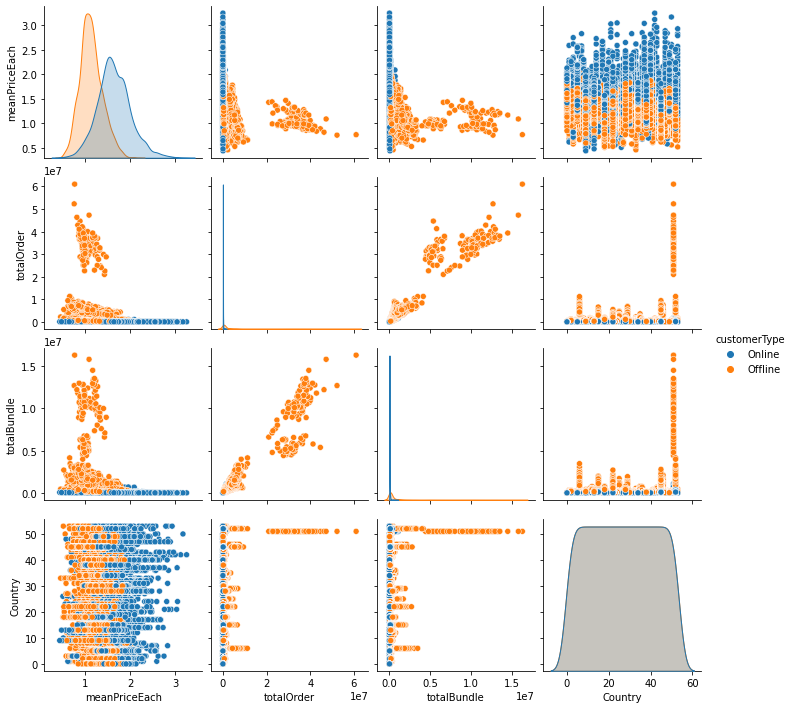

In [9]:
sns.pairplot(hue = 'customerType',
             data = df_pd,
             vars = ['meanPriceEach' , 'totalOrder' , 'totalBundle' , 'Country'])

plt.show()


# total order, total bundle 이 offline이 현저히 높음

## 2. 함수 생성

- Logistic Regression

In [28]:
def logisticRegression(model_id, X, y, ts = 0.3, rs = 2045) :

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = ts,
                                                      random_state = rs)
  
  # Model fitting
  LR = LogisticRegression()
  LR.fit(X_train, y_train)

  # Model predict
  y_hat = LR.predict(X_test)

  score_ac = LR.score(X_test, y_test)
  score_f1 = f1_score(y_test, y_hat, average = None)

  # Saving info in context
  context = {}
  context['model_id'] = model_id
  context['accuracy_score'] = score_ac
  context['f1_score'] = score_f1


  return context

- Decision Tree

In [64]:
def decisionTree(model_id, X, y, md = 3, ts = 0.3, rs = 2045, visualFeature = False, visualModel = False) :

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = ts,
                                                      random_state = 2045)
  
  # Model fitting
  DT = DecisionTreeClassifier(max_depth = md,
                              random_state = 2045)
  DT.fit(X_train, y_train)

  # Moel predict
  y_hat = DT.predict(X_test)

  if visualFeature:
    plt.figure(figsize = (9, 6))
    sns.barplot(DT.feature_importances_, X.columns)
    plt.title('Feature Importance')
    plt.show()

  if visualModel:
    g = graphviz.Source(export_graphviz(DT,
                                        class_names = (['Offline' , 'Online']),
                                        feature_names = X.columns,
                                        filled = True))
    display(g)

  score_ac = accuracy_score(y_test, y_hat)
  score_f1 = f1_score(y_test, y_hat, average = None)

  # Saving info in context
  context = {}
  context['model_id'] = model_id
  context['max_depth'] = md
  context['accuracy_score'] = score_ac
  context['f1_score'] = score_f1

  return context

- Random Forest

In [12]:
def randomForest(model_id, X, y, n_est = 100, mf = 'auto' , md = None, ts = 0.3, rs = 2045, visualFeature = False) :

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = ts,
                                                      random_state = 2045)
  
  # Model fitting
  RF = RandomForestClassifier(n_estimators = n_est,
                              max_features = mf,
                              max_depth = md,
                              random_state = rs)
  RF.fit(X_train, y_train)

  # Model predict
  y_hat = RF.predict(X_test)

  if visualFeature:
    plt.figure(figsize = (9, 6))
    sns.barplot(RF.feature_importances_, X.columns)
    plt.title('Feature Importance')
    plt.show()

  score_ac = accuracy_score(y_test, y_hat)
  score_f1 = f1_score(y_test, y_hat, average = None)

  # Saving info in context
  context = {}
  context['model_id'] = model_id
  context['n_estimators'] = n_est
  context['max_features'] = mf
  context['max_depth'] = md
  context['accuracy_score'] = score_ac
  context['f1_score'] = score_f1

  return context

## 2. Scaling

In [40]:
# 스케일링하지 않는 것이 성능이 더 좋음
X = df_pd[['meanPriceEach','totalOrder','orderType_1','orderType_2',
       'orderType_3','totalBundle','bundleType_1','bundleType_2',
       'FY','Country']]


scaler = MinMaxScaler()
df_pd[['meanPriceEach','totalOrder','orderType_1','orderType_2',
       'orderType_3','totalBundle','bundleType_1','bundleType_2',
       'FY','Country']] = scaler.fit_transform(X)
df_pd.head()

,Date,meanPriceEach,totalOrder,orderType_1,orderType_2,orderType_3,totalBundle,bundleType_1,bundleType_2,customerType,FY,Country
0,2015-01-04,0.398577,0.000950,0.000442,0.001232,0.001442,0.001173,0.001375,0.000424,Online,0.0,0.471698
1,2015-01-04,0.234875,0.042242,0.025293,0.064068,0.071103,0.031320,0.034150,0.018729,Offline,0.0,0.471698
2,2015-01-11,0.259786,0.038272,0.024628,0.050443,0.075209,0.033853,0.037062,0.019880,Offline,0.0,0.471698
3,2015-01-11,0.384342,0.001072,0.000641,0.001487,0.001245,0.001061,0.001330,0.000134,Online,0.0,0.471698
4,2015-01-18,0.430605,0.000860,0.000502,0.001236,0.001314,0.000766,0.000873,0.000352,Online,0.0,0.471698


In [57]:
df_res = pd.DataFrame(data = None,
                      columns = ['model_id',
                                 'n_estimators',
                                 'max_features',
                                 'max_depth',
                                 'accuracy_score',
                                 'f1_score'])

## 4. Logistic Regression

### 1) Case1: all

In [19]:
df_pd.columns

Index(['Date', 'meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2',
       'customerType', 'FY', 'Country'],
      dtype='object')

In [58]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2',
       'FY', 'Country']]
y = df_pd['customerType']

res = logisticRegression('LR-1' , X, y)

print(res)

df_res = df_res.append(res, ignore_index = True)

{'model_id': 'LR-1', 'accuracy_score': 0.9316011547856984, 'f1_score': array([0.92780122, 0.9350211 ])}


### 2) Case2: FY, totalOrder 제외

In [59]:
X = df_pd[['meanPriceEach', 'orderType_1', 'orderType_2', 'orderType_3',
           'totalBundle', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']

res = logisticRegression('LR-2' , X , y)

df_res = df_res.append(res, ignore_index = True)

In [54]:
df_res

,model_id,n_estimators,max_features,max_depth,accuracy_score,f1_score
0,LR-1,NaN,NaN,NaN,0.931601,"[0.9278012189404594, 0.9350210970464136]"
1,LR-2,NaN,NaN,NaN,0.932934,"[0.9311445508435932, 0.9346320346320346]"


### 3) Case3: FY, totalBundle 제외

In [60]:
X = df_pd[['meanPriceEach', 'totalOrder' , 'orderType_1', 'orderType_2', 'orderType_3',
           'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']

res = logisticRegression('LR-3' , X , y)

df_res = df_res.append(res, ignore_index = True)

In [61]:
df_res

,model_id,n_estimators,max_features,max_depth,accuracy_score,f1_score
0,LR-1,NaN,NaN,NaN,0.931601,"[0.9278012189404594, 0.9350210970464136]"
1,LR-2,NaN,NaN,NaN,0.932934,"[0.9311445508435932, 0.9346320346320346]"
2,LR-3,NaN,NaN,NaN,0.920720,"[0.9182130584192439, 0.9230769230769232]"


## 5. Decision Tree

In [62]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2',
       'FY', 'Country']]
y = df_pd['customerType']

In [65]:
res = decisionTree('DT-1' , X, y, 3)
print(res)
df_res = df_res.append(res, ignore_index = True)

{'model_id': 'DT-1', 'max_depth': 3, 'accuracy_score': 0.9475904952254053, 'f1_score': array([0.94891775, 0.94619243])}


In [66]:
df_res

,model_id,n_estimators,max_features,max_depth,accuracy_score,f1_score
0,LR-1,NaN,NaN,NaN,0.931601,"[0.9278012189404594, 0.9350210970464136]"
1,LR-2,NaN,NaN,NaN,0.932934,"[0.9311445508435932, 0.9346320346320346]"
2,LR-3,NaN,NaN,NaN,0.920720,"[0.9182130584192439, 0.9230769230769232]"
3,DT-1,NaN,NaN,3.0,0.947590,"[0.9489177489177488, 0.9461924304605563]"


In [68]:
res = decisionTree('DT-2' , X, y, 5)
print(res)
df_res = df_res.append(res, ignore_index = True)

{'model_id': 'DT-2', 'max_depth': 5, 'accuracy_score': 0.9782367310681768, 'f1_score': array([0.97804659, 0.9784236 ])}


In [69]:
df_res

,model_id,n_estimators,max_features,max_depth,accuracy_score,f1_score
0,LR-1,NaN,NaN,NaN,0.931601,"[0.9278012189404594, 0.9350210970464136]"
1,LR-2,NaN,NaN,NaN,0.932934,"[0.9311445508435932, 0.9346320346320346]"
2,LR-3,NaN,NaN,NaN,0.920720,"[0.9182130584192439, 0.9230769230769232]"
3,DT-1,NaN,NaN,3.0,0.947590,"[0.9489177489177488, 0.9461924304605563]"
4,DT-1,NaN,NaN,5.0,0.978237,"[0.9780465949820788, 0.9784236019374725]"
5,DT-2,NaN,NaN,5.0,0.978237,"[0.9780465949820788, 0.9784236019374725]"


In [70]:
res = decisionTree('DT-3' , X, y, 7)
print(res)
df_res = df_res.append(res, ignore_index = True)

{'model_id': 'DT-3', 'max_depth': 7, 'accuracy_score': 0.9844548079058405, 'f1_score': array([0.98443753, 0.98447205])}


In [71]:
df_res

,model_id,n_estimators,max_features,max_depth,accuracy_score,f1_score
0,LR-1,NaN,NaN,NaN,0.931601,"[0.9278012189404594, 0.9350210970464136]"
1,LR-2,NaN,NaN,NaN,0.932934,"[0.9311445508435932, 0.9346320346320346]"
2,LR-3,NaN,NaN,NaN,0.920720,"[0.9182130584192439, 0.9230769230769232]"
3,DT-1,NaN,NaN,3.0,0.947590,"[0.9489177489177488, 0.9461924304605563]"
4,DT-1,NaN,NaN,5.0,0.978237,"[0.9780465949820788, 0.9784236019374725]"
5,DT-2,NaN,NaN,5.0,0.978237,"[0.9780465949820788, 0.9784236019374725]"
6,DT-3,NaN,NaN,7.0,0.984455,"[0.9844375277901289, 0.9844720496894411]"


### 1) Modeling

In [ ]:
df_pd.columns

Index(['Date', 'meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2',
       'customerType', 'FY', 'Country'],
      dtype='object')

In [42]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data: ' , X_train.shape, y_train.shape)
print('Test Data: ' , X_test.shape, y_test.shape)

Train Data:  (10506, 10) (10506,)
Test Data:  (4503, 10) (4503,)


In [43]:
# 기본으로 모델 생성
RF = RandomForestClassifier(random_state = 2045 ,
                            n_jobs = -1)

RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2045, verbose=0,
                       warm_start=False)

In [44]:
y_hat = RF.predict(X_test)

### 2) Model Evaluate

In [45]:
acc_rf = accuracy_score(y_test, y_hat)

accuracy_score(y_test, y_hat)

0.9942260715078837

### 3) Feature Importance 확인

In [13]:
RF.feature_importances_

array([0.05322136, 0.2775662 , 0.0648896 , 0.09090657, 0.12854001,
       0.1050383 , 0.2074048 , 0.01563534, 0.00328381, 0.05351399])

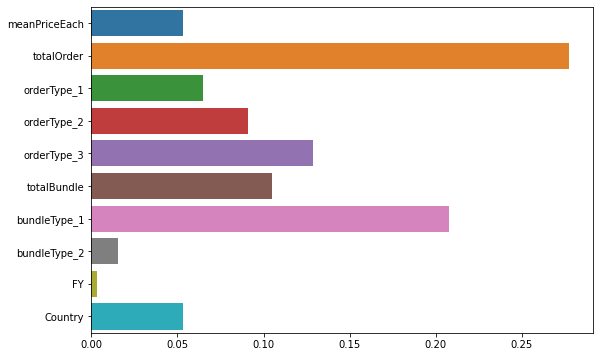

In [15]:
plt.figure(figsize = (9, 6))
sns.barplot(RF.feature_importances_,
            ['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country'])
plt.show()

## 3. Hyperparameter Tuning with GridSearchCV

In [16]:
params = {'n_estimators' : [100, 300, 500, 700, 900],
          'max_features' : [1, 2, 3, 4, 5],
          'max_depth' : [3, 4, 5, 6, 7],
          'random_state' : [2045]}

### 1) GridSearchCV 객체 생성

In [19]:
grid_cv = GridSearchCV(RF,
                       param_grid = params,
                       scoring = 'accuracy',
                       cv = KFold(n_splits = 5,
                                  random_state = 2045),
                       refit = True,
                       n_jobs = -1)

### 2) GridSearchCV 수행

In [21]:
start_time = datetime.now()

grid_cv.fit(X_train, y_train)

end_time = datetime.now()

print('Elapsed Time: ' , end_time - start_time)

# 39분 소요...

Elapsed Time:  0:39:18.465062


### 3) 최적의 Hyperparameter 확인

In [46]:
print('Best Accuracy: ' , grid_cv.best_score_)
print('Best Hyperparameter: ' , grid_cv.best_params_)
print('Best Model: ' , grid_cv.best_estimator_)

# 기본으로 생성한 모델보다 Accuracy가 낮다 (어째서 ㅠ)

Best Accuracy:  0.9930514715705584
Best Hyperparameter:  {'max_depth': 7, 'max_features': 4, 'n_estimators': 100, 'random_state': 2045}
Best Model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2045, verbose=0,
                       warm_start=False)


## 4. 최적 모델 생성 및 평가

In [48]:
model_CV = grid_cv.best_estimator_

y_hat = model_CV.predict(X_test)

In [49]:
model_CV.feature_importances_

array([0.04420163, 0.33282912, 0.03690108, 0.07602295, 0.09750733,
       0.10887006, 0.24657663, 0.00772306, 0.00184422, 0.04752391])

### 1) Feature Importance 확인

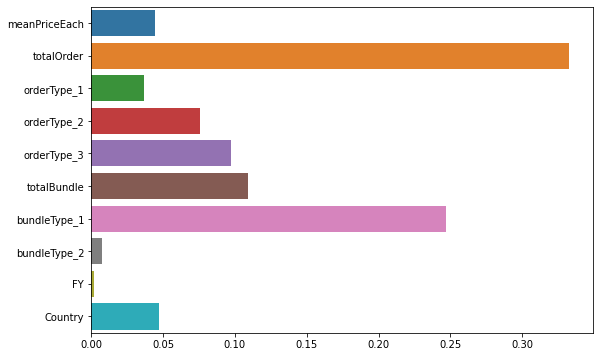

In [50]:
plt.figure(figsize = (9, 6))
sns.barplot(model_CV.feature_importances_,
            ['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country'])
plt.show()

### 2) 성능 확인

In [40]:
acc_CV = accuracy_score(y_test, y_hat)

accuracy_score(y_test, y_hat)

# 0.9888로 떨어짐!

0.9888962913613146

In [52]:
### 기본 DT에 Cross Validation을 없애면?
RF_2 = RandomForestClassifier(random_state = 2045 ,
                              max_depth = 7,
                              max_features = 4,
                              n_estimators = 100)

RF_2.fit(X_train, y_train)
y_hat_rf2 = RF_2.predict(X_test)

In [53]:
acc_rf2 = accuracy_score(y_test, y_hat_rf2)

acc_rf2

# 똑같다

0.9888962913613146

## 5. Logistic Regression, Decision Tree 결과와 비교

### 1) Logistic Regression 최적의 결과값

- Case1: 모든변수

In [27]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

LR_1 = LogisticRegression()
LR_1.fit(X_train, y_train)

y_hat_1 = LR_1.predict(X_test)

print('Train Accuracy: ' , LR_1.score(X_train, y_train))
print('Test Accuracy: ' , LR_1.score(X_test, y_test))

Train Accuracy:  0.9320388349514563
Test Accuracy:  0.9316011547856984


- Case2: FY, totalOrder 제외

In [54]:
X = df_pd[['meanPriceEach', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

LR_2 = LogisticRegression()
LR_2.fit(X_train, y_train)

y_hat_2 = LR_2.predict(X_test)

print('Train Accuracy: ' , LR_2.score(X_train, y_train))
print('Test Accuracy: ' , LR_2.score(X_test, y_test))
acc_lr = LR_2.score(X_test, y_test)

Train Accuracy:  0.9382257757471921
Test Accuracy:  0.9329335998223407


- Case3: FY, totalBundle 제외

In [29]:
X = df_pd[['meanPriceEach', 'totalOrder' , 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

LR_3 = LogisticRegression()
LR_3.fit(X_train, y_train)

y_hat_3 = LR_3.predict(X_test)

print('Train Accuracy: ' , LR_3.score(X_train, y_train))
print('Test Accuracy: ' , LR_3.score(X_test, y_test))

Train Accuracy:  0.9303255282695603
Test Accuracy:  0.9207195203197868


Logistic Regression의 최적의 Test Accuracy: 약 0.9329

### 2) Decision Tree
- 전체를 넣고 모델링
- feature importances 체크
- 필요없는 feature 제거 후 다시 모델링
- pruning

In [55]:
# 전체로 모델링

X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data: ' , X_train.shape, y_train.shape)
print('Test Data: ' , X_test.shape, y_test.shape)

Train Data:  (10506, 10) (10506,)
Test Data:  (4503, 10) (4503,)


In [56]:
DT_1 = DecisionTreeClassifier(random_state = 2045)
DT_1.fit(X_train, y_train)
y_hat_dt1 = DT_1.predict(X_test)

In [57]:
print('Train Accuracy: ' , DT_1.score(X_train, y_train))
print('Test Accuracy: ' , DT_1.score(X_test, y_test))

acc_dt = DT_1.score(X_test, y_test)
# overfitting

Train Accuracy:  1.0
Test Accuracy:  0.9882300688429936


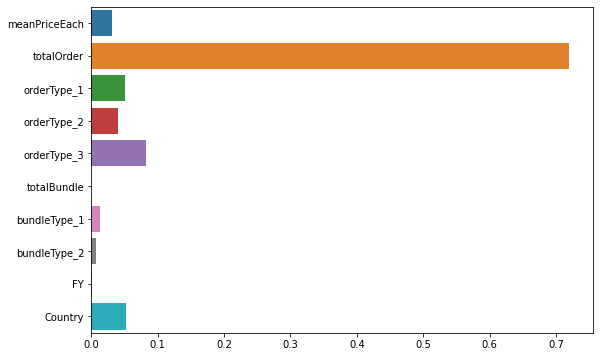

In [33]:
# feature importances 확인 - totalBundle, FY 기여도 없음

plt.figure(figsize = (9, 6))
sns.barplot(DT_1.feature_importances_,
            ['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country'])
plt.show()

- totalBundle, FY를 빼고 모델링

In [34]:
X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

In [35]:
DT_2 = DecisionTreeClassifier(random_state = 2045)
DT_2.fit(X_train, y_train)
y_hat_dt2 = DT_2.predict(X_test)

print('Train Accuracy: ' , DT_2.score(X_train, y_train))
print('Test Accuracy: ' , DT_2.score(X_test, y_test))

Train Accuracy:  1.0
Test Accuracy:  0.9864534754608039


In [36]:
# DT_1 pruning

X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'totalBundle', 'bundleType_1', 'bundleType_2', 'FY', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

DT_1 = DecisionTreeClassifier(max_depth = 6,
                              random_state = 2045)
DT_1.fit(X_train, y_train)
y_hat_dt1 = DT_1.predict(X_test)

In [37]:
print('Train Accuracy: ' , DT_1.score(X_train, y_train))
print('Test Accuracy: ' , DT_1.score(X_test, y_test))

Train Accuracy:  0.9903864458404721
Test Accuracy:  0.9831223628691983


In [59]:
# DT_2 pruning

X = df_pd[['meanPriceEach', 'totalOrder', 'orderType_1', 'orderType_2',
       'orderType_3', 'bundleType_1', 'bundleType_2', 'Country']]
y = df_pd['customerType']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

DT_2 = DecisionTreeClassifier(max_depth = 6,
                              min_samples_split = 9 ,
                              random_state = 2045)
DT_2.fit(X_train, y_train)
y_hat_dt2 = DT_2.predict(X_test)

In [60]:
print('Train Accuracy: ' , DT_2.score(X_train, y_train))
print('Test Accuracy: ' , DT_2.score(X_test, y_test))

acc_dt_pruned = DT_2.score(X_test, y_test)
# pruning 후 DT_1보다 정확도가 올라갔음을 볼 수 있다!

Train Accuracy:  0.9902912621359223
Test Accuracy:  0.9837885853875195


- 최적의 "Pruned" DecisionTree Test Accuracy: 약 0.9837

### 최종 Accuracy 비교

In [63]:
print('Logistic Regression: ' , acc_lr)
print('Decision Tree: ' , acc_dt)
print('Decision Tree(pruned): ' , acc_dt_pruned)
print('Random Forest: ' , acc_rf)
print('Rundom Froest with GridSearchCV: ' , acc_CV)

Logistic Regression:  0.9329335998223407
Decision Tree:  0.9882300688429936
Decision Tree(pruned):  0.9837885853875195
Random Forest:  0.9942260715078837
Rundom Froest with GridSearchCV:  0.9888962913613146
